# Coursework CNN

The objective of this project is to classify a kidney cortex cell image set sourced through the Broad Bioimage Benchmark Collection (BBBC)  into 8 classes of different cells. 

## Basic Imports

For this coursework, we will be needing Keras, Numpy and Tensorflow. <br>
We will build our CNN in Keras wiht elements of tensorflow <br>
Numpy will be mainly used for dataset preprocessing.

In [ ]:
import keras
import numpy as np

from numpy.random import seed
import tensorflow as tf

# Kaggle Set up and Data Imports
We will connect to kaggle with our username and key along with our URN.<br>
Then the dataset will be downloaded straight form Kaggle.

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'taimoorrizwan'  # Your Kaggle username
os.environ['KAGGLE_KEY'] = '4a1584ff4e78601137d1ed2ca93dc228'  # Your Kaggle API key
os.environ['URN'] = '6716747'  # Your URN: submissions without a URN will not count

In [ ]:
!python3 /usr/local/bin/kaggle competitions download -c uos-com2028-21-22-cw --force
!unzip uos-com2028-21-22-cw.zip

403 - Forbidden
unzip:  cannot find or open uos-com2028-21-22-cw.zip, uos-com2028-21-22-cw.zip.zip or uos-com2028-21-22-cw.zip.ZIP.


# Data Manipulation

The Data set obtained form kaggle in its original state is seperated into training set(150,000 images), testing set(50,000 images) and train.csv file containing image Ids and their corresponding class.

### Seperation
Data will be seperated into folders with differnt class labels ranging from 0 to 7. These folders will be automactically generated in a new training folder labeled train_cat. For this we will employ shutil class.

In [ ]:
import shutil, os
import pandas as pd

data = pd.read_csv("train.csv",converters={'Id': lambda x: str(x)})
data = data.sort_values('Cell type')
class_names = [0,1,2,3,4,5,6,7]

train_images = '/train'
train_cat = '/train_cat'
#creating subfolders
for i in class_names:
  os.makedirs(os.path.join('train_cat', str(i)))

In [ ]:
for c in class_names: # Category Name
    for i in list(data[data['Cell type']==c]['Id']): # Image Id
        get_image = os.path.join('train', str(i)+'.jpg') # Path to Images 
        move_image_to_cat = shutil.move(get_image, 'train_cat/'+str(c))

# Data Preprocessing

We will seperated the Training dataset into a 80:20 ratio to training: validation sets. Where the training and validation sets will have 120,000 and 30,000 images respectively. Furthermore, the color mode will be set to grayscale with image size of (28x28). Finally we will use the batchsize of 128.

In [ ]:
from pandas.core.arrays import categorical
from tensorflow.keras.utils import image_dataset_from_directory
import time
# Up to you: RGB is default, but perhaps colours aren't that helpful...?
colour_mode = 'grayscale'

#moving the image files to their respective categories

# Up to you: change the image size if desired. Perhaps they don't need to be that big.
image_size = (28, 28)

# Up to you: training batch size.
batch_size = 128

train_kidney_dataset = image_dataset_from_directory(                                               
  'train_cat',
  color_mode=colour_mode,
  validation_split=0.2,
  subset='training',
  seed=42,
  label_mode="categorical",
  image_size=image_size,
  batch_size=batch_size)

validation_kidney_dataset = image_dataset_from_directory(
  'train_cat',
  color_mode=colour_mode,
  validation_split=0.2,
  subset='validation',
  seed=42,
  label_mode= "categorical",
  image_size=image_size,
  batch_size=batch_size)

test_kidney_dataset = image_dataset_from_directory(
  'test',
  shuffle=False,  # Important: the test dataset order must match Kaggle!
  labels=None,  # Important: the test dataset has no labels...
  color_mode=colour_mode,
  image_size=image_size,
  batch_size=1)  # Don't batch the test samples.

print('Train label names:', train_kidney_dataset.class_names)
print('Test label names (empty):', test_kidney_dataset.class_names)

Found 150000 files belonging to 8 classes.
Using 120000 files for training.
Found 150000 files belonging to 8 classes.
Using 30000 files for validation.
Found 50000 files belonging to 1 classes.
Train label names: ['0', '1', '2', '3', '4', '5', '6', '7']
Test label names (empty): ['']


# Confusion Matrix

This function to generate a Confusion Matrix has been sourced form "Draw Confusion Matrix for CNN models" - LESLIE'S BLOG 2020-06-22
<br>Further Refreneces:
1. https://deeplizard.com/learn/video/0LhiS6yu2qQ
2. https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, title, cmap=None, normalize=False):
    """
    arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
    target_names = ('0','1','2','3','4','5','6','7') 
    if cmap is None:
        cmap = plt.get_cmap('GnBu')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    


# **Basic Model**

For this Coursework we will use the following as base model that will be refered to in the report. We will then use vairous tecnhiques to overcome the appent issues of overfitting and data variation/imbalance.

In [ ]:
from time import time
import tensorflow as tf
from keras import optimizers
from keras.layers import Rescaling
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.engine.training import Model
from keras.layers import Dense, Conv2D, Flatten
from tensorflow.python.keras.callbacks import TensorBoard

input_shape=(28,28,1)

Base = Sequential()
Base.add(Rescaling(1./255))

Base.add(Conv2D(32, kernel_size=(1, 1), activation='relu', input_shape=input_shape)) 
Base.add(Conv2D(32, kernel_size=(1,1), activation='relu'))
Base.add(Conv2D(64, kernel_size=(3, 3),padding = 'same', activation='relu'))
Base.add(MaxPooling2D(pool_size=(2, 2)))

Base.add(Conv2D(64, kernel_size=(3, 3),padding = 'same', activation='relu'))
Base.add(Conv2D(128, kernel_size=(3, 3),padding = 'same', activation='relu'))
Base.add(MaxPooling2D(pool_size=(2, 2)))

Base.add(Conv2D(128, kernel_size=(3, 3),padding = 'same', activation='relu'))
Base.add(Conv2D(256, kernel_size=(3, 3),padding = 'same', activation='relu'))
Base.add(MaxPooling2D(pool_size=(3, 3)))

Base.add(Flatten())

Base.add(Dense(8, activation='softmax'))
Base.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
tensorboard = TensorBoard(log_dir = "logs/{}".format(time()))
Base_history = Base.fit(train_kidney_dataset, validation_data=validation_kidney_dataset,epochs=50, verbose=1, callbacks=[tensorboard])
Base.summary()

Epoch 1/50
938/938 [==============================] - 37s 27ms/step - loss: 1.3362 - accuracy: 0.5078 - val_loss: 1.2372 - val_accuracy: 0.5459
Epoch 2/50
938/938 [==============================] - 23s 25ms/step - loss: 1.1546 - accuracy: 0.5739 - val_loss: 1.1494 - val_accuracy: 0.5734
Epoch 3/50
938/938 [==============================] - 23s 25ms/step - loss: 1.0842 - accuracy: 0.6003 - val_loss: 1.0968 - val_accuracy: 0.5943
Epoch 4/50
938/938 [==============================] - 24s 25ms/step - loss: 1.0255 - accuracy: 0.6230 - val_loss: 1.0891 - val_accuracy: 0.5955
Epoch 5/50
938/938 [==============================] - 24s 25ms/step - loss: 0.9674 - accuracy: 0.6447 - val_loss: 1.1011 - val_accuracy: 0.5988
Epoch 6/50
938/938 [==============================] - 23s 25ms/step - loss: 0.9037 - accuracy: 0.6700 - val_loss: 1.1577 - val_accuracy: 0.5907
Epoch 7/50
938/938 [==============================] - 24s 25ms/step - loss: 0.8327 - accuracy: 0.6972 - val_loss: 1.1985 - val_accuracy:

## Base Model Evaluation

### CNN Model Summary

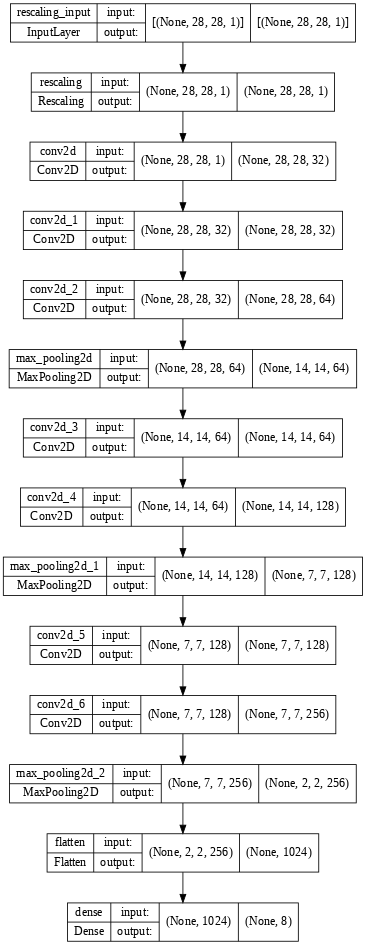

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(Base, to_file='Base_plot.png', show_shapes=True, show_layer_names=True, dpi = 60)

### Confusion Matrix

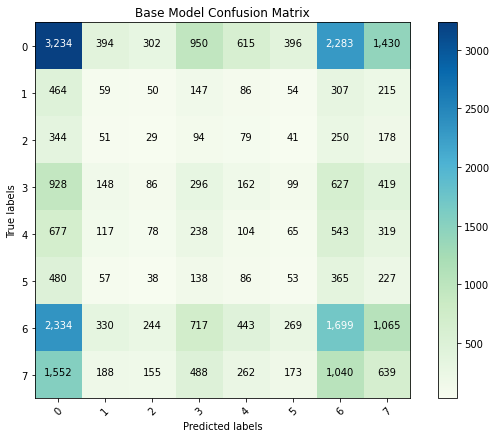

In [ ]:
# importing the library
import tensorflow as tf
from sklearn.metrics import confusion_matrix
 
# Initializing the input tensor
labels = validation_kidney_dataset
labels = tf.concat([y for x, y in validation_kidney_dataset], axis=0)
labels = np.argmax(labels, axis=-1)
predictions = Base.predict(validation_kidney_dataset)
predictions = np.argmax(predictions, axis=-1)
cm = confusion_matrix(labels,predictions)

#print('Confusion_matrix: ',cm)
title = "Base Model Confusion Matrix"
plot_confusion_matrix(cm, title)

### Train Vs Validation Graphs

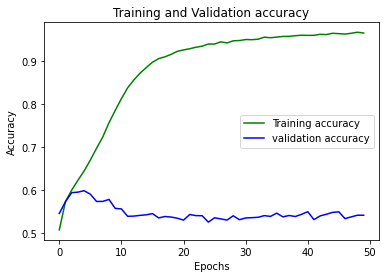

In [ ]:
loss_train = Base_history.history['accuracy']
loss_val = Base_history.history['val_accuracy']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Model 1**

In [ ]:
from keras import optimizers
import tensorflow as tf
from keras.engine.training import Model
from time import time
from keras.layers import Rescaling
from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import Dropout
from keras.layers import MaxPool2D
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.python.keras.callbacks import TensorBoard

# Your code here: create the model
input_shape=(28,28,1)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

model1 = Sequential()
model1.add(tf.keras.layers.RandomFlip(
    mode="horizontal_and_vertical", seed=None))

model1.add(Rescaling(1./255))

model1.add(Conv2D(32, kernel_size=(1, 1), activation='relu', input_shape=input_shape)) # change to 16 -> 32
model1.add(Conv2D(32, kernel_size=(1,1), activation='relu'))
model1.add(Conv2D(64, kernel_size=(3, 3),padding = 'same', activation='relu'))# change to 16 -> 32
model1.add(MaxPooling2D(pool_size=(2, 2)))


model1.add(Conv2D(64, kernel_size=(3, 3),padding = 'same', activation='relu'))# change to 32 -> 64
model1.add(Conv2D(128, kernel_size=(3, 3),padding = 'same', activation='relu'))# Added new
model1.add(MaxPooling2D(pool_size=(2, 2)))




model1.add(Conv2D(128, kernel_size=(3, 3),padding = 'same', activation='relu'))
model1.add(Conv2D(256, kernel_size=(3, 3),padding = 'same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(3, 3)))


model1.add(Flatten())

model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(8, activation='softmax'))
#(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
tensorboard = TensorBoard(log_dir = "logs/{}".format(time()))
erls = EarlyStopping(monitor='val_loss', mode='auto', verbose=1,patience = 10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience = 3, factor=0.15, min_lr=0.000001, verbose=1)
model1_history = model1.fit(train_kidney_dataset, validation_data=validation_kidney_dataset,epochs=50, verbose=1, callbacks=[reduce_lr,tensorboard])
model1.summary()

Epoch 1/50
938/938 [==============================] - 28s 29ms/step - loss: 1.3545 - accuracy: 0.4985 - val_loss: 1.2189 - val_accuracy: 0.5499 - lr: 0.0010
Epoch 2/50
938/938 [==============================] - 26s 28ms/step - loss: 1.1928 - accuracy: 0.5594 - val_loss: 1.1397 - val_accuracy: 0.5767 - lr: 0.0010
Epoch 3/50
938/938 [==============================] - 26s 27ms/step - loss: 1.1352 - accuracy: 0.5799 - val_loss: 1.0978 - val_accuracy: 0.5898 - lr: 0.0010
Epoch 4/50
938/938 [==============================] - 26s 28ms/step - loss: 1.0983 - accuracy: 0.5932 - val_loss: 1.0703 - val_accuracy: 0.6060 - lr: 0.0010
Epoch 5/50
938/938 [==============================] - 26s 28ms/step - loss: 1.0696 - accuracy: 0.6049 - val_loss: 1.0644 - val_accuracy: 0.6047 - lr: 0.0010
Epoch 6/50
938/938 [==============================] - 26s 28ms/step - loss: 1.0534 - accuracy: 0.6112 - val_loss: 1.0588 - val_accuracy: 0.6103 - lr: 0.0010
Epoch 7/50
938/938 [==============================] - 26s 

## Model 1 Evaluation

### CNN Model Summary

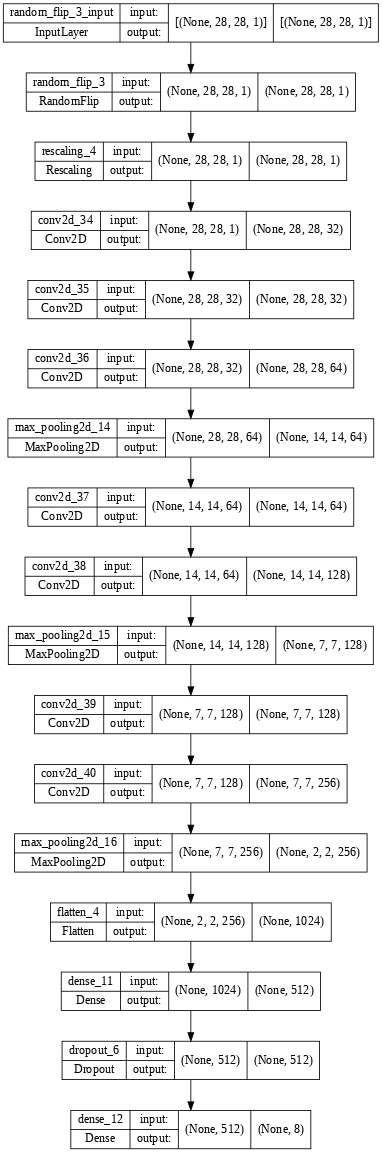

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model1, to_file='model1_plot.png', show_shapes=True, show_layer_names=True, dpi = 60)

### Confusion Matrix

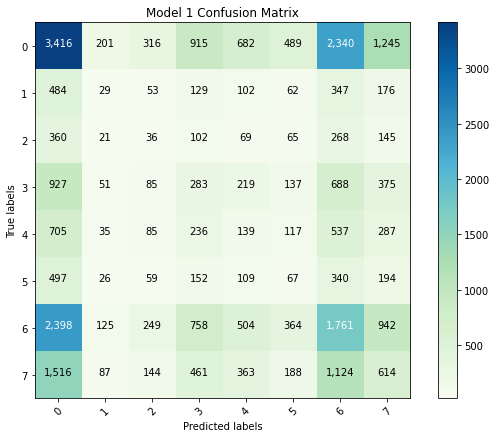

In [ ]:
# importing the library
import tensorflow as tf
from sklearn.metrics import confusion_matrix
 
# Initializing the input tensor
labels = validation_kidney_dataset
labels = tf.concat([y for x, y in validation_kidney_dataset], axis=0)
labels = np.argmax(labels, axis=-1)
predictions = model1.predict(validation_kidney_dataset)
predictions = np.argmax(predictions, axis=-1)
cm = confusion_matrix(labels,predictions)

#print('Confusion_matrix: ',cm)
title = "Model 1 Confusion Matrix"
plot_confusion_matrix(cm, title)

### Train Vs Validation Graphs

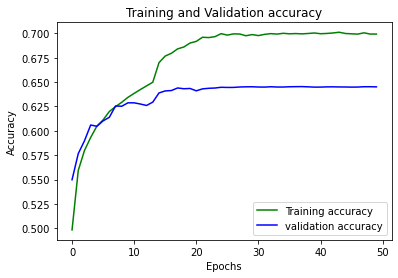

In [ ]:
loss_train = model1_history.history['accuracy']
loss_val = model1_history.history['val_accuracy']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Model** 2

In [ ]:
from keras import optimizers
import tensorflow as tf
from keras.engine.training import Model
from time import time
from keras.layers import Rescaling
from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import Dropout
from keras.layers import MaxPool2D
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.python.keras.callbacks import TensorBoard
input_shape=(28,28,1)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

model2 = Sequential()
model2.add(tf.keras.layers.RandomFlip(
    mode="horizontal_and_vertical", seed=None))
model2.add(Rescaling(1./255))

model2.add(Conv2D(64, kernel_size=(1, 1), activation='relu', input_shape=input_shape)) # change to 16 -> 32
model2.add(Conv2D(64, kernel_size=(5,5), activation='relu',padding = 'same'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, kernel_size=(3, 3),padding = 'same', activation='relu'))# change to 16 -> 32
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Conv2D(128, kernel_size=(3, 3),padding = 'same', activation='relu'))# change to 32 -> 64
model2.add(BatchNormalization())
model2.add(Conv2D(128, kernel_size=(3, 3),padding = 'same', activation='relu'))# Added new
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Conv2D(128, kernel_size=(3, 3),padding = 'same', activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(256, kernel_size=(3, 3),padding = 'same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(256, kernel_size=(3, 3),padding = 'same', activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(256, kernel_size=(3, 3),padding = 'same', activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(512, kernel_size=(3, 3),padding = 'same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(512, activation='sigmoid'))
model2.add(BatchNormalization())
model2.add(Dense(8, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])
tensorboard = TensorBoard(log_dir = "logs/{}".format(time()))
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.15,patience = 3, mode = 'min', min_lr=0.000001, verbose=1)
model2_history = model2.fit(train_kidney_dataset, validation_data=validation_kidney_dataset,epochs=50, verbose=1, callbacks=[reduce_lr,tensorboard])
model2.summary()

Epoch 1/50
938/938 [==============================] - 46s 47ms/step - loss: 1.3257 - accuracy: 0.5153 - val_loss: 1.3143 - val_accuracy: 0.5152 - lr: 0.0010
Epoch 2/50
938/938 [==============================] - 53s 56ms/step - loss: 1.1685 - accuracy: 0.5678 - val_loss: 1.4725 - val_accuracy: 0.4524 - lr: 0.0010
Epoch 3/50
938/938 [==============================] - 81s 86ms/step - loss: 1.1101 - accuracy: 0.5904 - val_loss: 1.2603 - val_accuracy: 0.5566 - lr: 0.0010
Epoch 4/50
938/938 [==============================] - 101s 107ms/step - loss: 1.0674 - accuracy: 0.6063 - val_loss: 1.1229 - val_accuracy: 0.5826 - lr: 0.0010
Epoch 5/50
938/938 [==============================] - 40s 43ms/step - loss: 1.0384 - accuracy: 0.6187 - val_loss: 1.1374 - val_accuracy: 0.5912 - lr: 0.0010
Epoch 6/50
938/938 [==============================] - 41s 43ms/step - loss: 1.0089 - accuracy: 0.6291 - val_loss: 1.0739 - val_accuracy: 0.6029 - lr: 0.0010
Epoch 7/50
938/938 [==============================] - 41

## Model 2 Evaluation

### CNN Model Summary

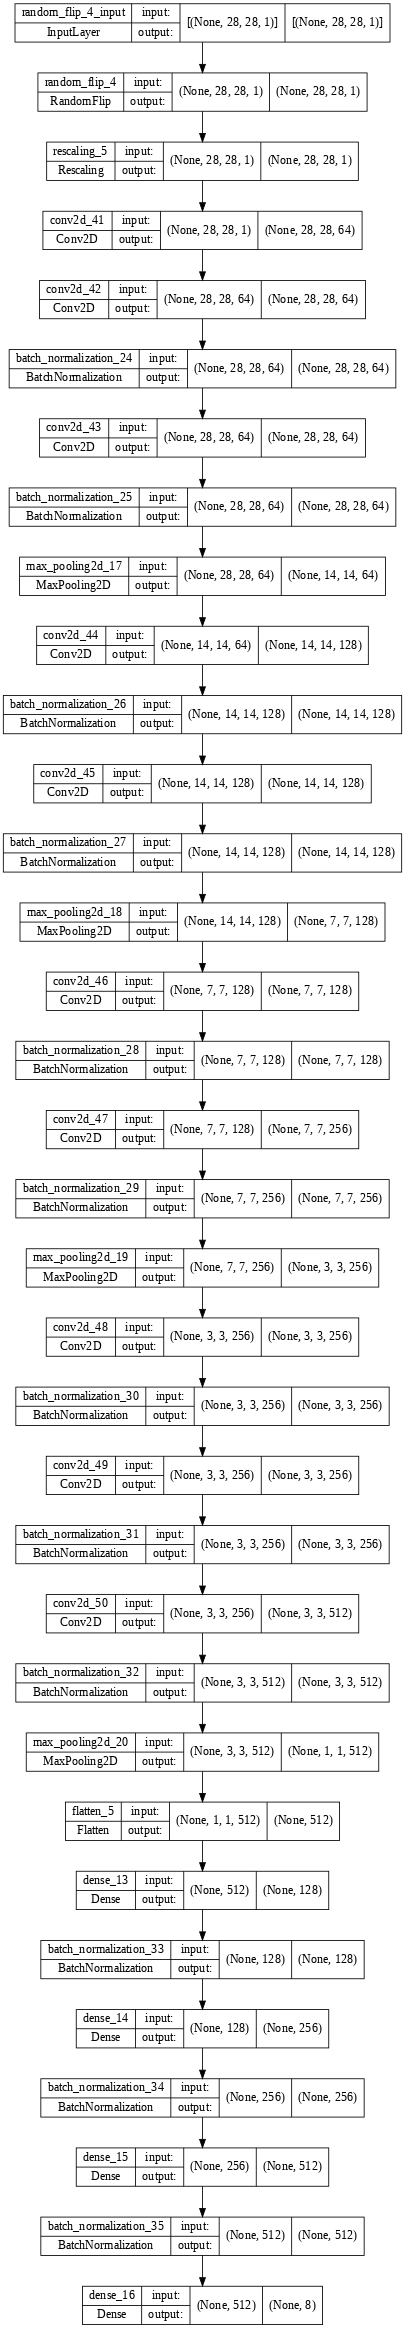

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='model2_plot.png', show_shapes=True, show_layer_names=True, dpi = 60)

### Confusion Matrix

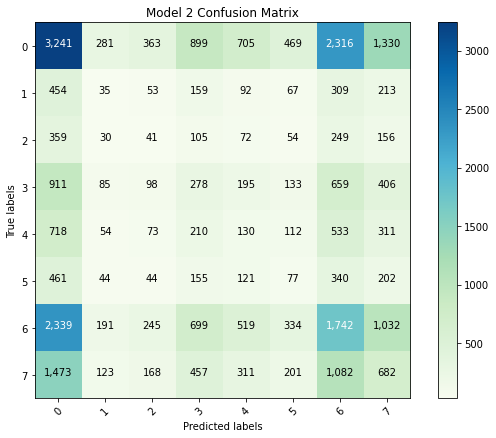

In [ ]:
# importing the library
import tensorflow as tf
from sklearn.metrics import confusion_matrix
 
# Initializing the input tensor
labels = validation_kidney_dataset
labels = tf.concat([y for x, y in validation_kidney_dataset], axis=0)
labels = np.argmax(labels, axis=-1)
predictions = model2.predict(validation_kidney_dataset)
predictions = np.argmax(predictions, axis=-1)
cm = confusion_matrix(labels,predictions)

#print('Confusion_matrix: ',cm)
title = "Model 2 Confusion Matrix"
plot_confusion_matrix(cm, title)

### Train Vs Validation Graphs

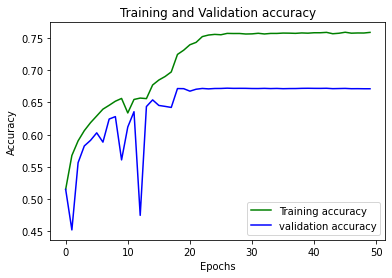

In [ ]:
loss_train = model2_history.history['accuracy']
loss_val = model2_history.history['val_accuracy']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Final Model**

In [ ]:
from keras import optimizers
import tensorflow as tf
from keras.engine.training import Model
from time import time
# To normalise the dataset without first loading the images into memory, we can use a Rescaling layer.
# This means images are normalised when given as input to the model.
from keras.layers import Rescaling
from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import Dropout
from keras.layers import MaxPool2D
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization
#import tensorflow_addons as tfa
# Your code here: create the model
input_shape=(28,28,1)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

finalmodel = Sequential()
finalmodel.add(tf.keras.layers.RandomFlip(
    mode="horizontal_and_vertical", seed=None))
finalmodel.add(Rescaling(1./255))

finalmodel.add(Conv2D(64, kernel_size=(1, 1), activation='relu', input_shape=input_shape)) # change to 16 -> 32
finalmodel.add(Conv2D(64, kernel_size=(5,5), activation='relu',padding = 'same'))
finalmodel.add(BatchNormalization())
finalmodel.add(Conv2D(64, kernel_size=(3, 3),padding = 'same', activation='relu'))# change to 16 -> 32
finalmodel.add(BatchNormalization())
finalmodel.add(MaxPooling2D(pool_size=(2, 2)))
finalmodel.add(Dropout(0.25))

finalmodel.add(Conv2D(128, kernel_size=(3, 3),padding = 'same', activation='relu'))# change to 32 -> 64
finalmodel.add(BatchNormalization())
finalmodel.add(Conv2D(128, kernel_size=(3, 3),padding = 'same', activation='relu'))# Added new
finalmodel.add(BatchNormalization())
finalmodel.add(MaxPooling2D(pool_size=(2, 2)))
finalmodel.add(Dropout(0.25))

finalmodel.add(Conv2D(128, kernel_size=(3, 3),padding = 'same', activation='relu'))
finalmodel.add(BatchNormalization())
finalmodel.add(Conv2D(256, kernel_size=(3, 3),padding = 'same', activation='relu'))
finalmodel.add(BatchNormalization())
finalmodel.add(MaxPooling2D(pool_size=(2, 2)))
finalmodel.add(Dropout(0.25))
finalmodel.add(Conv2D(256, kernel_size=(3, 3),padding = 'same', activation='relu'))
finalmodel.add(BatchNormalization())
finalmodel.add(Conv2D(256, kernel_size=(3, 3),padding = 'same', activation='relu'))
finalmodel.add(BatchNormalization())
finalmodel.add(Conv2D(512, kernel_size=(3, 3),padding = 'same', activation='relu'))
finalmodel.add(BatchNormalization())
finalmodel.add(MaxPooling2D(pool_size=(2, 2)))
finalmodel.add(Dropout(0.25))

finalmodel.add(Flatten())
finalmodel.add(Dense(128, activation='relu'))
finalmodel.add(BatchNormalization())
finalmodel.add(Dense(256, activation='relu'))
finalmodel.add(BatchNormalization())
finalmodel.add(Dense(512, activation='sigmoid'))
finalmodel.add(BatchNormalization())
finalmodel.add(Dropout(0.5))

finalmodel.add(Dense(8, activation='softmax'))
finalmodel.compile(loss='categorical_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])
erls = EarlyStopping(monitor='val_loss', mode='auto', verbose=1,patience = 10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.15,patience = 3, mode = 'min', min_lr=0.000001, verbose=1)
finalmodel_history = finalmodel.fit(train_kidney_dataset, validation_data=validation_kidney_dataset,epochs=50, verbose=1, callbacks=[reduce_lr])
finalmodel.summary()

Epoch 1/50
938/938 [==============================] - 49s 50ms/step - loss: 1.5232 - accuracy: 0.4694 - val_loss: 1.3364 - val_accuracy: 0.5239 - lr: 0.0010
Epoch 2/50
938/938 [==============================] - 68s 72ms/step - loss: 1.2338 - accuracy: 0.5470 - val_loss: 1.2523 - val_accuracy: 0.5358 - lr: 0.0010
Epoch 3/50
938/938 [==============================] - 42s 45ms/step - loss: 1.1688 - accuracy: 0.5716 - val_loss: 1.1559 - val_accuracy: 0.5808 - lr: 0.0010
Epoch 4/50
938/938 [==============================] - 42s 45ms/step - loss: 1.1281 - accuracy: 0.5868 - val_loss: 1.1644 - val_accuracy: 0.5726 - lr: 0.0010
Epoch 5/50
938/938 [==============================] - 43s 45ms/step - loss: 1.0962 - accuracy: 0.5983 - val_loss: 1.2759 - val_accuracy: 0.5804 - lr: 0.0010
Epoch 6/50
938/938 [==============================] - 43s 45ms/step - loss: 1.0689 - accuracy: 0.6082 - val_loss: 1.0392 - val_accuracy: 0.6206 - lr: 0.0010
Epoch 7/50
938/938 [==============================] - 45s 

## Final Model Evaluation

### CNN Model Summary

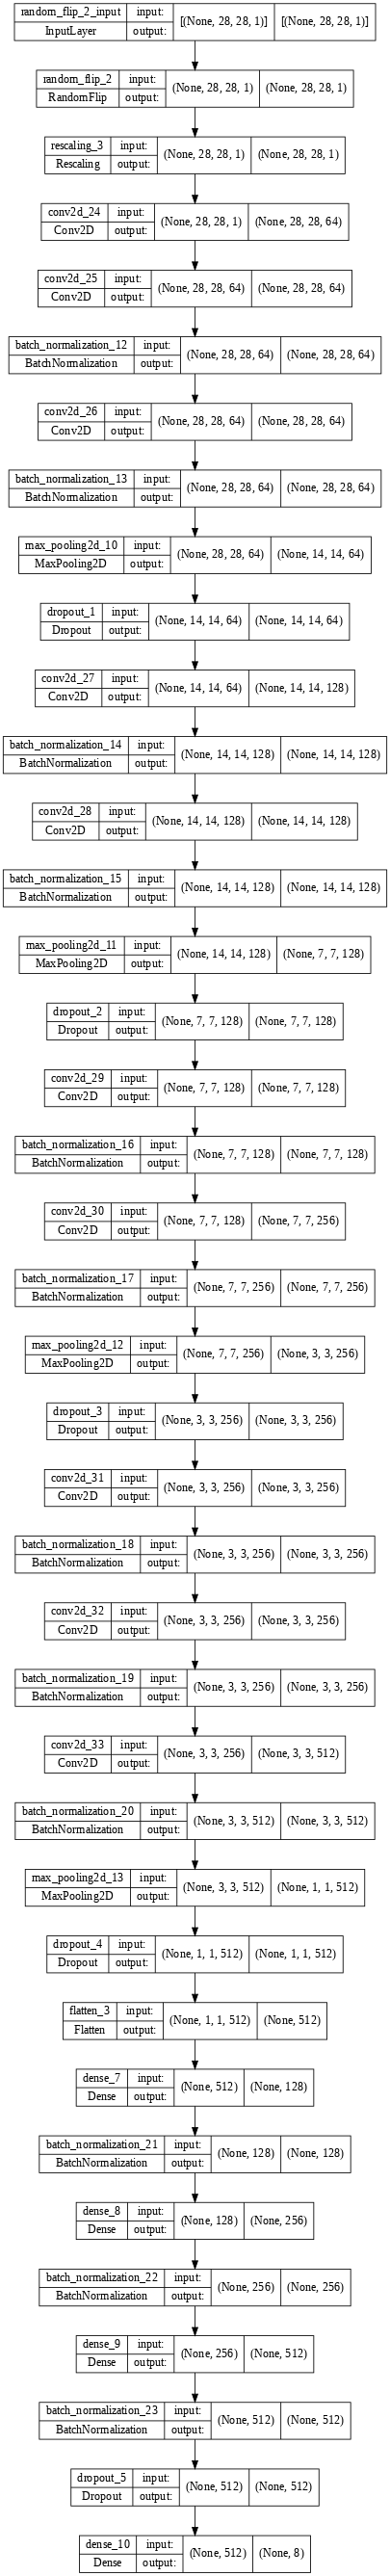

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(finalmodel, to_file='finalmodel_plot.png', show_shapes=True, show_layer_names=True, dpi = 60)

### Confusion Matrix

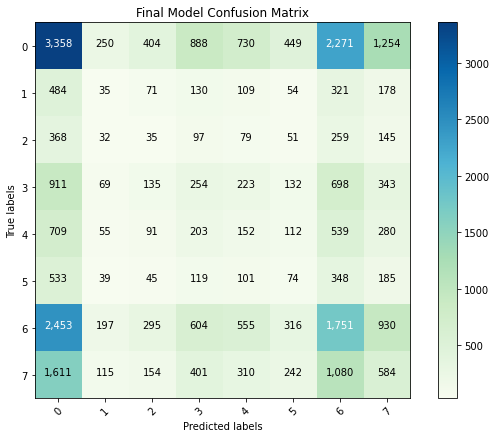

In [ ]:
# importing the library
import tensorflow as tf
from sklearn.metrics import confusion_matrix
 
# Initializing the input tensor
labels = validation_kidney_dataset
labels = tf.concat([y for x, y in validation_kidney_dataset], axis=0)
labels = np.argmax(labels, axis=-1)
predictions = finalmodel.predict(validation_kidney_dataset)
predictions = np.argmax(predictions, axis=-1)
cm = confusion_matrix(labels,predictions)

#print('Confusion_matrix: ',cm)
title = "Final Model Confusion Matrix"
plot_confusion_matrix(cm, title)

### Train Vs Validation Graphs

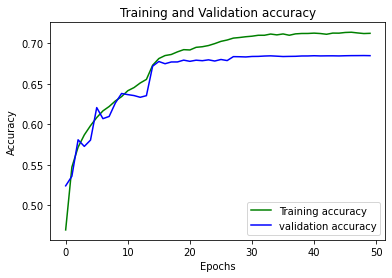

In [ ]:
loss_train = finalmodel_history.history['accuracy']
loss_val = finalmodel_history.history['val_accuracy']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



# Final Submission

In [ ]:
predictions = finalmodel.predict(test_kidney_dataset)
print(predictions)
predictions = np.argmax(predictions, axis=-1)
print(predictions)

[[6.26246631e-01 6.22546263e-02 1.23435154e-03 ... 6.66087260e-03
  1.40681997e-01 1.40996754e-01]
 [9.70480125e-03 2.00184455e-04 8.52290952e-07 ... 1.98961789e-04
  9.18688476e-01 7.09771514e-02]
 [5.77175543e-02 9.30414051e-02 1.98501701e-04 ... 3.94945499e-04
  7.15343952e-02 7.58725822e-01]
 ...
 [1.70332026e-02 9.42436218e-01 2.05477932e-07 ... 1.54026316e-06
  3.16198282e-02 8.60846601e-03]
 [1.01225801e-01 1.08770365e-02 6.06800995e-06 ... 1.25986247e-04
  3.99453878e-01 4.87946093e-01]
 [8.26956034e-02 1.42973885e-02 1.26485527e-03 ... 5.26462402e-03
  6.21078491e-01 9.42327082e-02]]
[0 6 7 ... 1 7 6]


In [ ]:
from pandas import DataFrame
DataFrame(data={'Cell type': predictions}).to_csv('predictions.csv', index_label='Id')

In [ ]:
!python3 /usr/local/bin/kaggle competitions submit -m $URN -c uos-com2028-21-22-cw -f predictions.csv

100% 380k/380k [00:08<00:00, 45.8kB/s]
Successfully submitted to COM2028 21/22 CW